In [2]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Load and check data

In [7]:
PROCESSED_DATA_FOLDER = "data/4_all_data_preprocessed"
DATASET_FILE = "all_features"

In [8]:
# Load dataset
dataset = pickle.load(open(f"{PROCESSED_DATA_FOLDER}/{DATASET_FILE}.pkl", "rb"))

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192867 entries, 0 to 192866
Columns: 760 entries, city_resolvedAddress to isw_zone
dtypes: Sparse[float64, 0](718), bool(1), float64(38), object(3)
memory usage: 841.3+ MB


In [10]:
# Check the size of the data
dataset.shape

(192867, 760)

In [11]:
# Check few lines
dataset.head()

,city_resolvedAddress,day_datetime,isw_date_tomorrow_datetime,event_indicator,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,...,isw_work,isw_would,isw_wound,isw_year,isw_yet,isw_yevgeni,isw_zaporizhia,isw_zaporizhzhia,isw_znpp,isw_zone
0,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
1,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
2,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
3,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
4,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0


In [12]:
# Check nan
dataset.isna().sum()

city_resolvedAddress          0
day_datetime                  0
isw_date_tomorrow_datetime    0
event_indicator               0
day_tempmax                   0
                             ..
isw_yevgeni                   0
isw_zaporizhia                0
isw_zaporizhzhia              0
isw_znpp                      0
isw_zone                      0
Length: 760, dtype: int64

In [13]:
dataset.dtypes

city_resolvedAddress                      object
day_datetime                              object
isw_date_tomorrow_datetime                object
event_indicator                             bool
day_tempmax                              float64
                                     ...        
isw_yevgeni                   Sparse[float64, 0]
isw_zaporizhia                Sparse[float64, 0]
isw_zaporizhzhia              Sparse[float64, 0]
isw_znpp                      Sparse[float64, 0]
isw_zone                      Sparse[float64, 0]
Length: 760, dtype: object

In [14]:
# Sort dataset by date
dataset['day_datetime'] = pd.to_datetime(dataset['day_datetime'])
dataset = dataset.sort_values(by='day_datetime')
dataset.day_datetime.describe(datetime_is_numeric=True)

count                           192867
mean     2022-08-02 23:32:38.163916288
min                2022-02-25 00:00:00
25%                2022-05-10 00:00:00
50%                2022-08-02 00:00:00
75%                2022-10-24 00:00:00
max                2023-01-20 00:00:00
Name: day_datetime, dtype: object

In [15]:
# Extract relevant date features
dataset['year'] = pd.to_datetime(dataset['day_datetime']).dt.year
dataset['month'] = pd.to_datetime(dataset['day_datetime']).dt.month
dataset['day'] = pd.to_datetime(dataset['day_datetime']).dt.day
dataset['day_of_week'] = pd.to_datetime(dataset['day_datetime']).dt.dayofweek

In [16]:
# Translate city names
dataset.rename(columns = {'city_resolvedAddress':'city'}, inplace=True)
dataset['city'].unique()

array(['Луцьк, Луцький район, Україна', 'Житомир, Україна',
       'Рівне, Україна', 'Полтава, Україна', 'Тернопіль, Україна',
       'Ужгород, Ужгородський район, Україна', 'Донецьк, Україна',
       'Запоріжжя, Україна', 'Суми, Україна', 'Черкаси, Україна',
       'Вінниця, Україна', 'Львів, Україна', 'Івано-Франківськ, Україна',
       'Херсон, Україна', 'Київ, Україна', 'Дніпро, Україна',
       'Чернівці, Україна', 'Кропивницький, Україна', 'Харків, Україна',
       'Миколаїв, Україна', 'Хмельницька область, Україна',
       'Одеса, Україна', 'Чернігів, Україна'], dtype=object)

In [17]:
region_dict = {
    "Київ, Україна" : 'Kyiv', 
    "Миколаїв, Україна" : 'Mykolaiv',
    "Дніпро, Україна": 'Dnipro',
    "Харків, Україна" : 'Kharkiv', 
    "Житомир, Україна": 'Zhytomyr',
    "Кропивницький, Україна": 'Kropyvnytskyi',
    "Запоріжжя, Україна": 'Zaporizhzhia',
    "Полтава, Україна": 'Poltava',
    "Чернігів, Україна": 'Chernihiv',
    "Одеса, Україна": 'Odesa',
    "Хмельницька область, Україна": 'Khmelnytskyi',
    "Черкаси, Україна": 'Cherkasy',
    "Суми, Україна": 'Sumy',
    "Вінниця, Україна": 'Vinnytsia',
    "Херсон, Україна": 'Kherson',
    "Львів, Україна": 'Lviv',
    "Луцьк, Луцький район, Україна": 'Lutsk',
    "Рівне, Україна": 'Rivne',
    "Івано-Франківськ, Україна": 'Ivano-Frankivsk',
    "Тернопіль, Україна": 'Ternopil',
    "Чернівці, Україна": 'Chernivtsi',
    "Ужгород, Ужгородський район, Україна": 'Uzhhorod',
    "Донецьк, Україна": 'Donetsk'
}

dataset = dataset.replace({"city": region_dict})

In [18]:
# Define target variable
dataset['target'] = dataset['event_indicator']
dataset = dataset.drop(columns=['event_indicator', 'isw_date_tomorrow_datetime'])

# Check the event proportion of the data
dataset['target'] = dataset['target'].astype(int)
dataset['target'].value_counts()

0    143773
1     49094
Name: target, dtype: int64

[Text(0.5, 1.0, 'Countplot of events')]

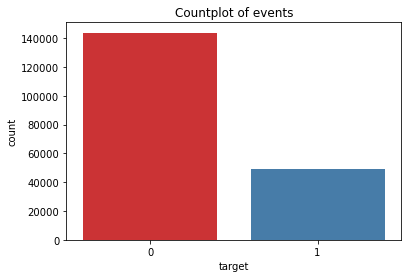

In [19]:
np.float = float
sns.countplot(x='target', data=dataset, palette='Set1').set(title = "Countplot of events")

Text(0, 0.5, 'Number of Air alerts')

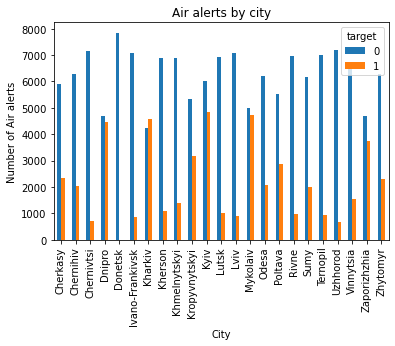

In [20]:
#%matplotlib inline
pd.crosstab(dataset['city'], dataset['target']).plot(kind='bar')
plt.rcParams["figure.figsize"] = [15, 5]
plt.title('Air alerts by city')
plt.xlabel('City')
plt.ylabel('Number of Air alerts')

In [70]:
# Create id column for each unique city
cities = dataset['city'].unique()
city_dict = {cities[i]: i+1 for i in range(len(cities))}
dataset['city_id'] = dataset['city'].map(city_dict)
dataset.drop('city', axis=1, inplace=True)

KeyError: 'city'

# Model Selection

In [71]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(random_state=5, class_weight="balanced")

# Support Vector Machines
from sklearn import svm
models['Support Vector Machines'] = svm.SVC(random_state=5, class_weight="balanced")

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
models['Stochastic Gradient Descent'] = SGDClassifier(random_state=5, class_weight="balanced", loss="log_loss")

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(random_state=5, class_weight="balanced")

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['AdaBoost'] = AdaBoostClassifier(random_state=5)


# XGBoost
from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(random_state=5, objective='binary:logistic', booster='gbtree')

In [72]:
models

{'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=5),
 'Support Vector Machines': SVC(class_weight='balanced', random_state=5),
 'Stochastic Gradient Descent': SGDClassifier(class_weight='balanced', loss='log_loss', random_state=5),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=5),
 'AdaBoost': AdaBoostClassifier(random_state=5),
 'XGBoost': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weig

# Model Training

In [73]:
min_date = dataset['day_datetime'].min()
max_date = dataset['day_datetime'].max()
print("Min:", min_date, "Max:", max_date)

Min: 2022-02-25 00:00:00 Max: 2023-01-20 00:00:00


In [74]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2022-10-29 18:00:00')

In [75]:
train_df = dataset[dataset['day_datetime'] <= train_cutoff]
test_df = dataset[dataset['day_datetime'] > train_cutoff]

In [76]:
# Split the dataset into features (X) and target (y)
X_train, X_test = train_df.drop(columns=['target', 'day_datetime']), test_df.drop(columns=['target', 'day_datetime'])
y_train, y_test = train_df['target'], test_df['target']

In [ ]:
predict, predict_proba, accuracy, precision, recall, f1_score = {}, {}, {}, {}, {}, {}

for key in models.keys():
    print(key)

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    test_pred = models[key].predict(X_test)
    test_prob = models[key].predict_proba(X_test)[:, 1]

    # Calculate metrics
    predict[key] = test_pred
    predict_proba[key] = test_prob
    accuracy[key] = accuracy_score(test_pred, y_test)
    precision[key] = precision_score(test_pred, y_test)
    recall[key] = recall_score(test_pred, y_test)
    f1_score[key] = f1_score(test_pred, y_test)
    print(accuracy[key], precision[key], recall[key])

Logistic Regression


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kali

0.2895885493984446 0.9916678239133454 0.18242898017576128
Support Vector Machines


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

In [ ]:
for key in models.keys():
    print(f"Confusion matrix for {key}")
    print(confusion_matrix(y_test, test_pred[key]))

In [44]:
# Confusion matrix
print(confusion_matrix(y_test, predictions))

# Classification report
print(classification_report(y_test, predictions))

[[36497  1435]
 [ 2257  4944]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     37932
           1       0.78      0.69      0.73      7201

    accuracy                           0.92     45133
   macro avg       0.86      0.82      0.84     45133
weighted avg       0.92      0.92      0.92     45133



# Model Evaluation

In [26]:
# Split the dataset into features (X) and target (y)
X = dataset.drop(columns=['target'])
y = dataset['target']

# Set the duration of each test set to 2 months
test_duration = timedelta(days=60)

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=len(dataset)//test_duration.days)

    
# Loop over the splits
for train_index, test_index in tscv.split(X):
    # Get the start and end times of the test set
    test_start_time = X.iloc[test_index[0]]['day_datetime']
    test_end_time = X.iloc[test_index[-1]]['day_datetime']

    # Split the data into train and test sets based on the time duration of the test set
    train_mask = (X['day_datetime'] < test_start_time) | (X['day_datetime'] > test_end_time)
    test_mask = (X['day_datetime'] >= test_start_time) & (X['day_datetime'] <= test_end_time)
    X_train, X_test = X.loc[train_mask].drop(columns=['day_datetime']), X.loc[test_mask].drop(columns=['day_datetime'])
    y_train, y_test = y.loc[train_mask], y.loc[test_mask]

    # Train your machine learning model using X_train and y_train
    models['Logistic Regression'].fit(X_train, y_train)

    # Evaluate your model on the test set
    accuracy = models['Logistic Regression'.score(X_test, y_test)
    print(f"Accuracy: {accuracy}")

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NameError: name 'model' is not defined

In [27]:
len(dataset)//test_duration.days

3214

In [ ]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

In [ ]:
pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)